<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Understanding COVID-19 with Pandas and NetworkX</h1>
<h1>Simple Models: Part II</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 792f78317ecef2e33990957fccb9f5b18773bf8c

watermark : 2.1.0
scipy     : 1.6.1
json      : 2.0.9
numpy     : 1.19.2
pandas    : 1.1.3
matplotlib: 3.3.2
networkx  : 2.5



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## SIR Model

A more interesting and realistic model is the SIR model. It allows people to recover from the infection after some time, so now we have 3 compartments and 2 transitions

In [4]:
beta = 0.2
mu = 0.1
N = 100000
I0 = 10


SIR = EpiModel()
SIR.add_interaction('S', 'I', 'I', beta)
SIR.add_spontaneous('I', 'R', mu)

In [5]:
print(SIR)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.200000
I -> R 0.100000

R0=2.00


And the dynamics is more interesting as well:

In [6]:
SIR.integrate(365, S=N-I0, I=I0, R=0)

And a quick visualization

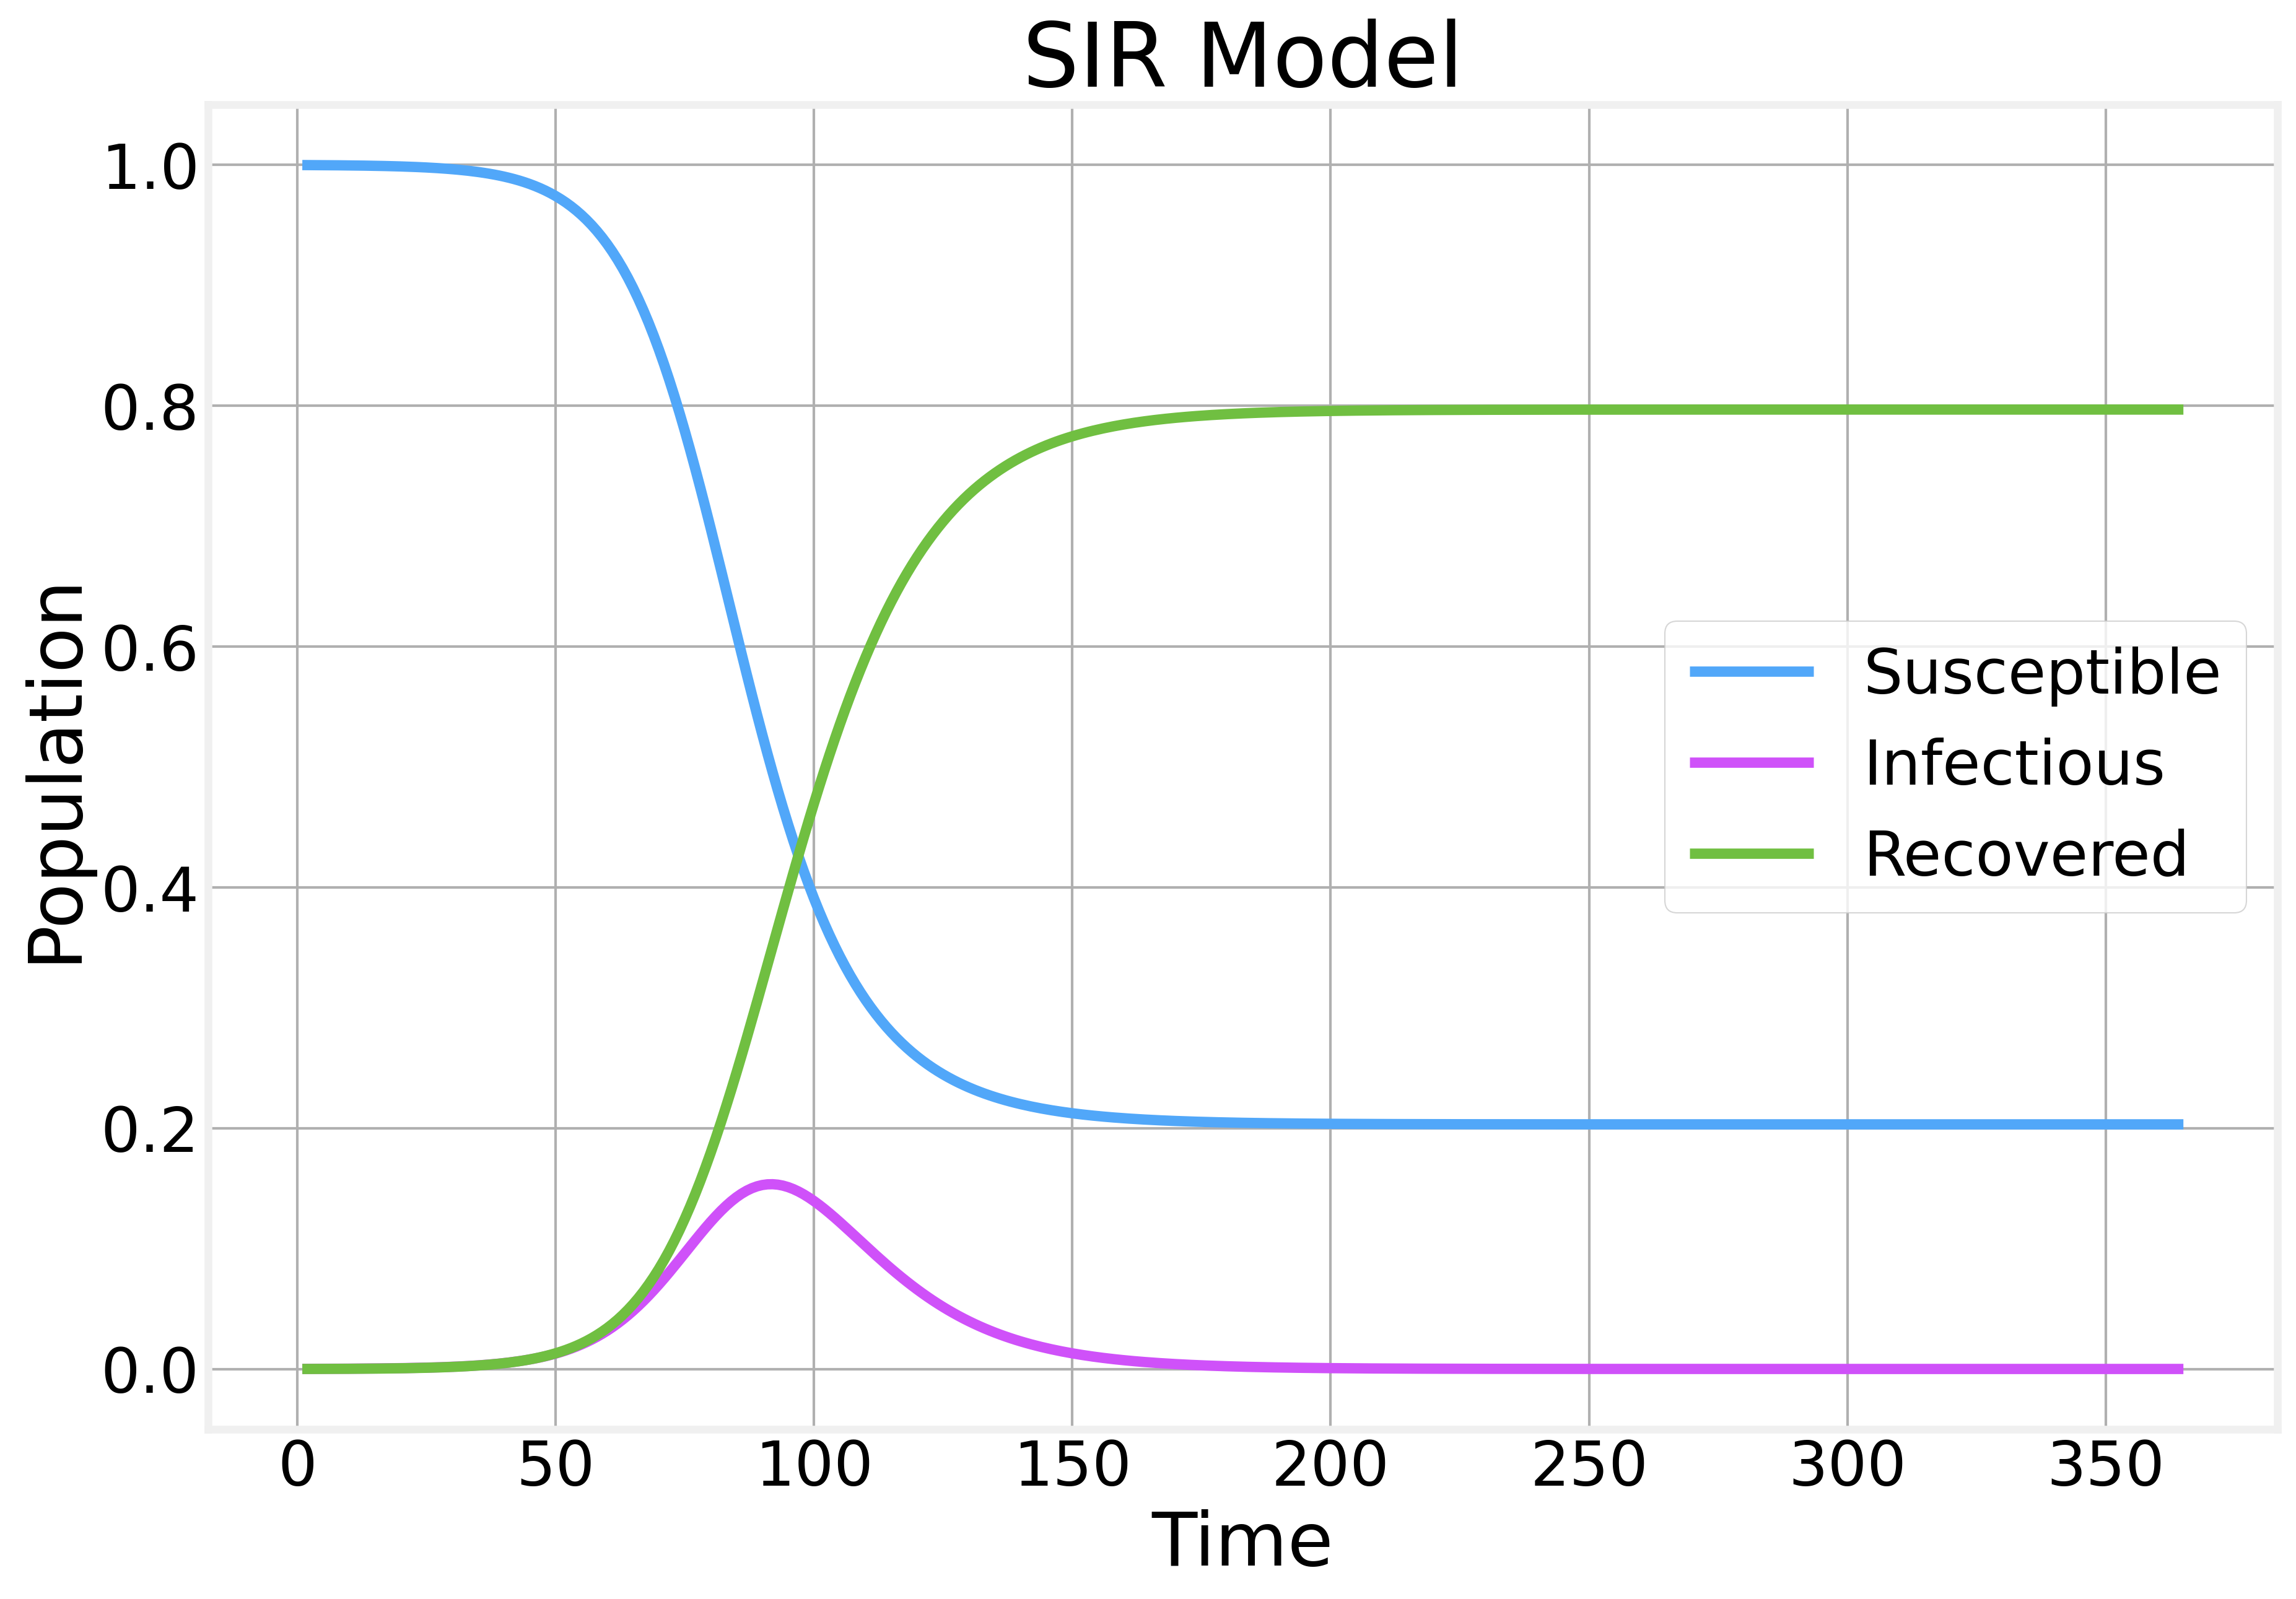

In [7]:
ax = SIR.plot('SIR Model', normed=True)
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

The purple line is the number of currently infectious cases as a function of time. As we can see, not all of the population is infectious at the same time, and, in fact, only about $80\%$ of the population is ever infected, as shown by the green curve representing the fraction of recovered.

The typical bell curve you're likely to see (as asked to flatten) is simply the number of infectious individuals as a function of time:

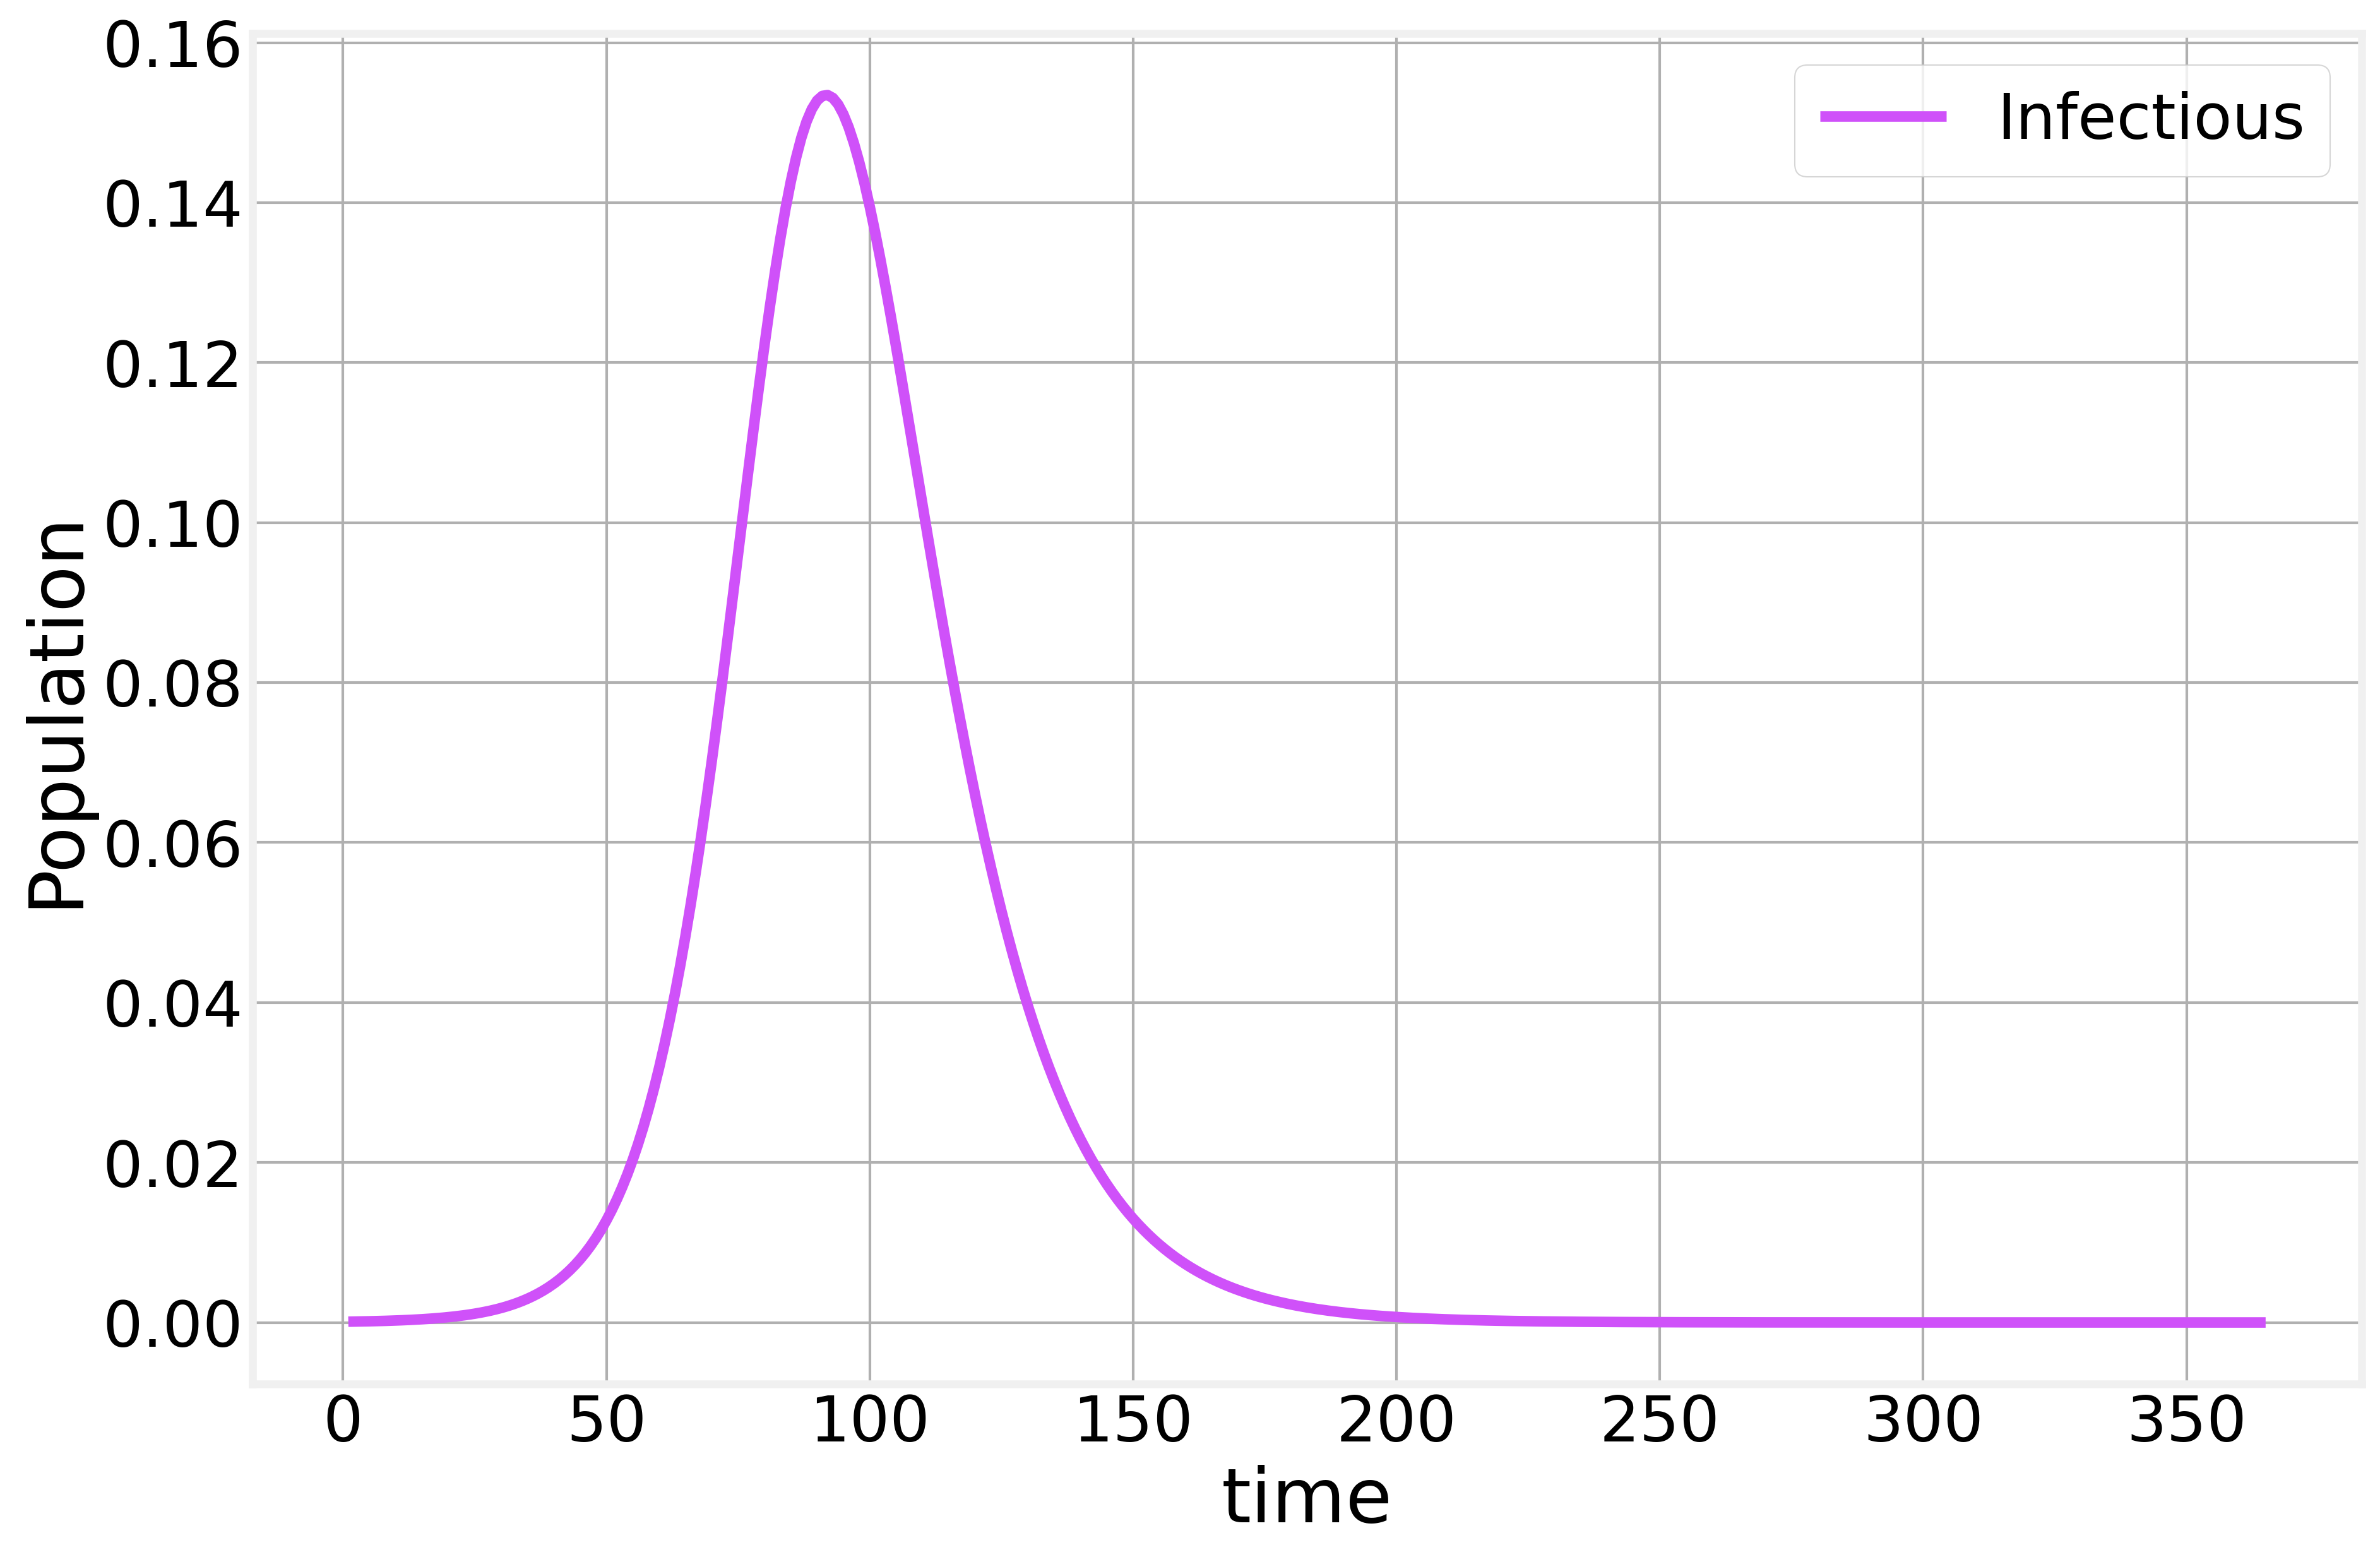

In [8]:
ax=(SIR.I/N).plot(label='Infectious', color=colors[1])
ax.set_xlabel('time')
ax.set_ylabel('Population')
ax.legend()

## Lockdown

A consequence of this is that even if you completely cut the supply of Susceptibles who become Infected it takes some time for the effects to be seen. We illustrate this more clearly by implementing a simple lockdown strategy. Starting at time 75, we implement our lockdown strategy and completly stop new infections from occurring. We do this by replacing the epidemic model with one where people are only allowed to recover.

We start with the original SIR model as before and integrating for the first 75 days

In [9]:
beta = 0.2
mu = 0.1

SIR2 = EpiModel()
SIR2.add_interaction('S', 'I', 'I', beta)
SIR2.add_spontaneous('I', 'R', mu)

SIR2.integrate(75, S=N-I0, I=I0, R=0)

Now we create new model with just one transition and setting the initial population to be the population at the end of the previous process

In [10]:
Quarantine = EpiModel('SIR')
Quarantine.add_spontaneous('I', 'R', mu)

population = SIR2.values_.iloc[-1]
S0 = population.S
I0 = population.I
R0 = population.R

Quarantine.integrate(365-74, S=S0, I=I0, R=R0)

In [11]:
Quarantine

Epidemic Model with 3 compartments and 1 transitions:

I -> R 0.100000

Now we compbine the results from the two models

In [12]:
values = pd.concat([SIR2.values_, Quarantine.values_], axis=0, ignore_index=True)

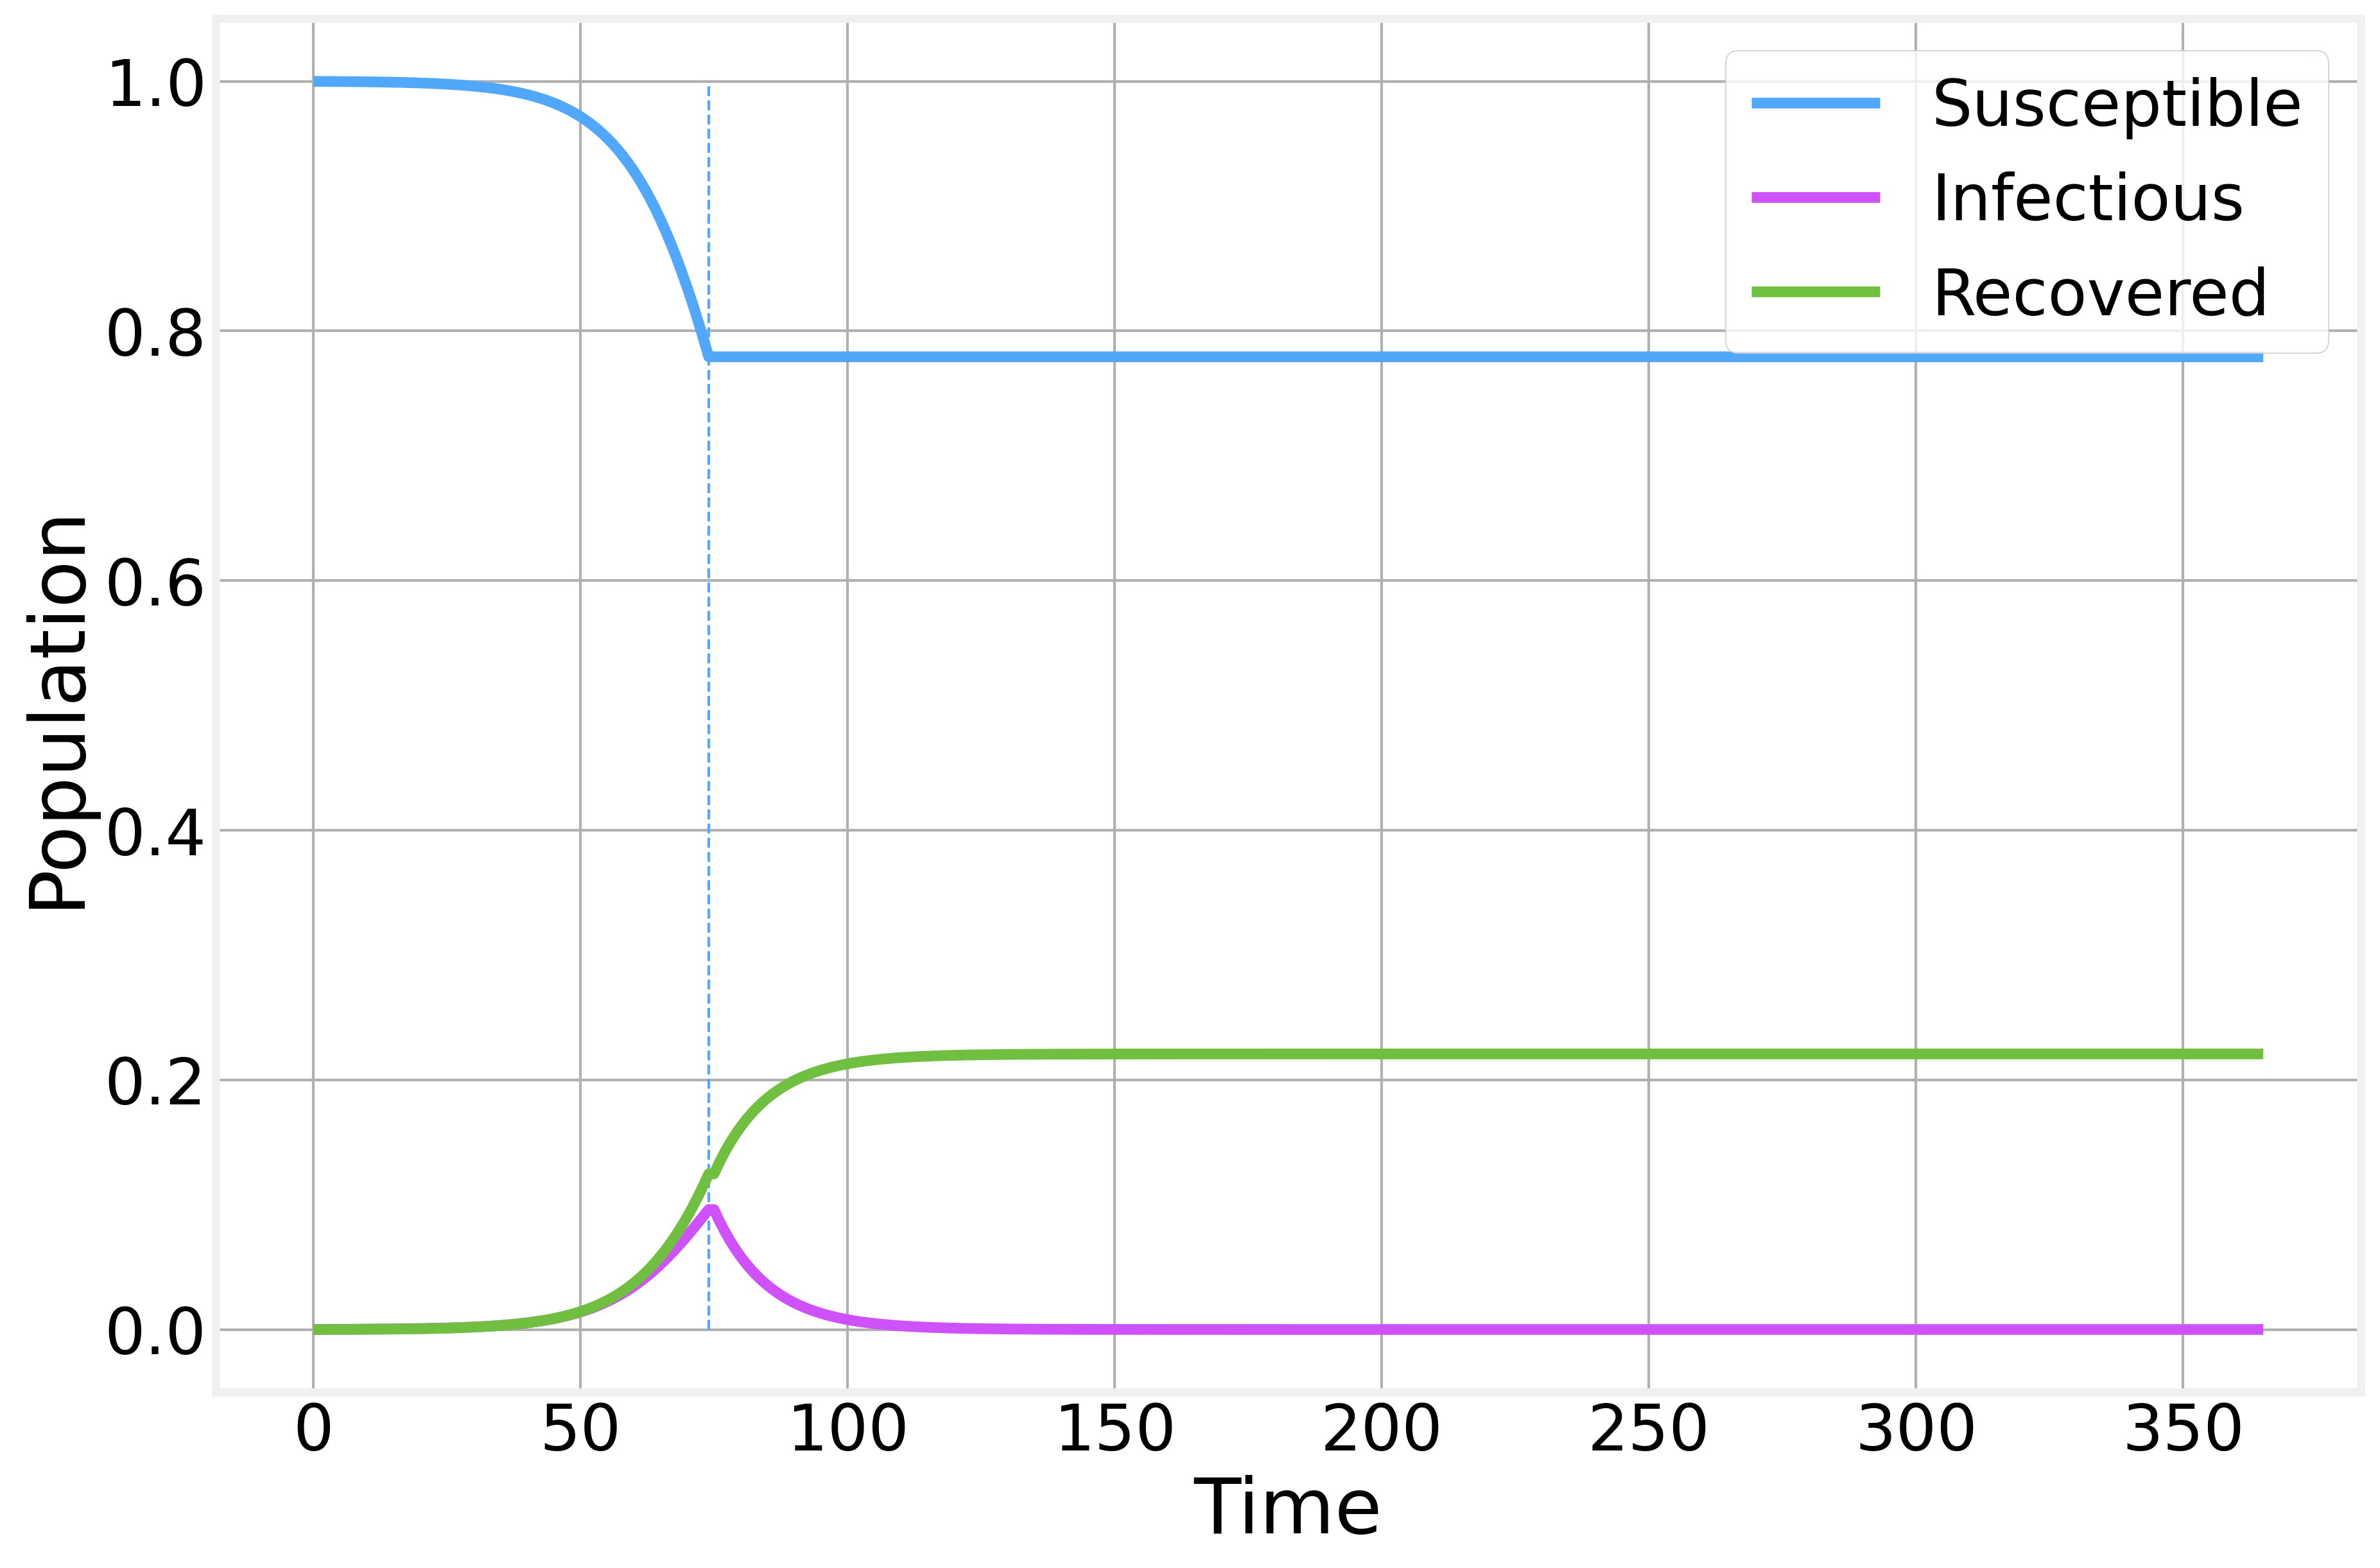

In [13]:
ax = (values/N).plot()
ax.vlines(x=74, ymax=1, ymin=0, lw=1, linestyle='--')
ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

Even in this idealized scenario it still takes ~25 days before all the infectious individual recover and life can go back to normal.

If, instead, we have the more realistic scenario where instead of completely stopping the spread we reduce the the spreading $R_0$ to, say, 0.5 (the perfect scenario was equivalent to $R_0=0$, so that the epidemic becomes non viable, we have:

In [14]:
beta = 0.2/4 # Reduce R0 by 4.
mu = 0.1

Quarantine2 = EpiModel()
Quarantine2.add_interaction('S', 'I', 'I', beta)
Quarantine2.add_spontaneous('I', 'R', mu)

Quarantine2.integrate(365-74, S=S0, I=I0, R=R0)

values2 = pd.concat([SIR2.values_, Quarantine2.values_], axis=0, ignore_index=True)

Now we can compare the two scenarios. Lighter dashed lines representing the perfect case described above

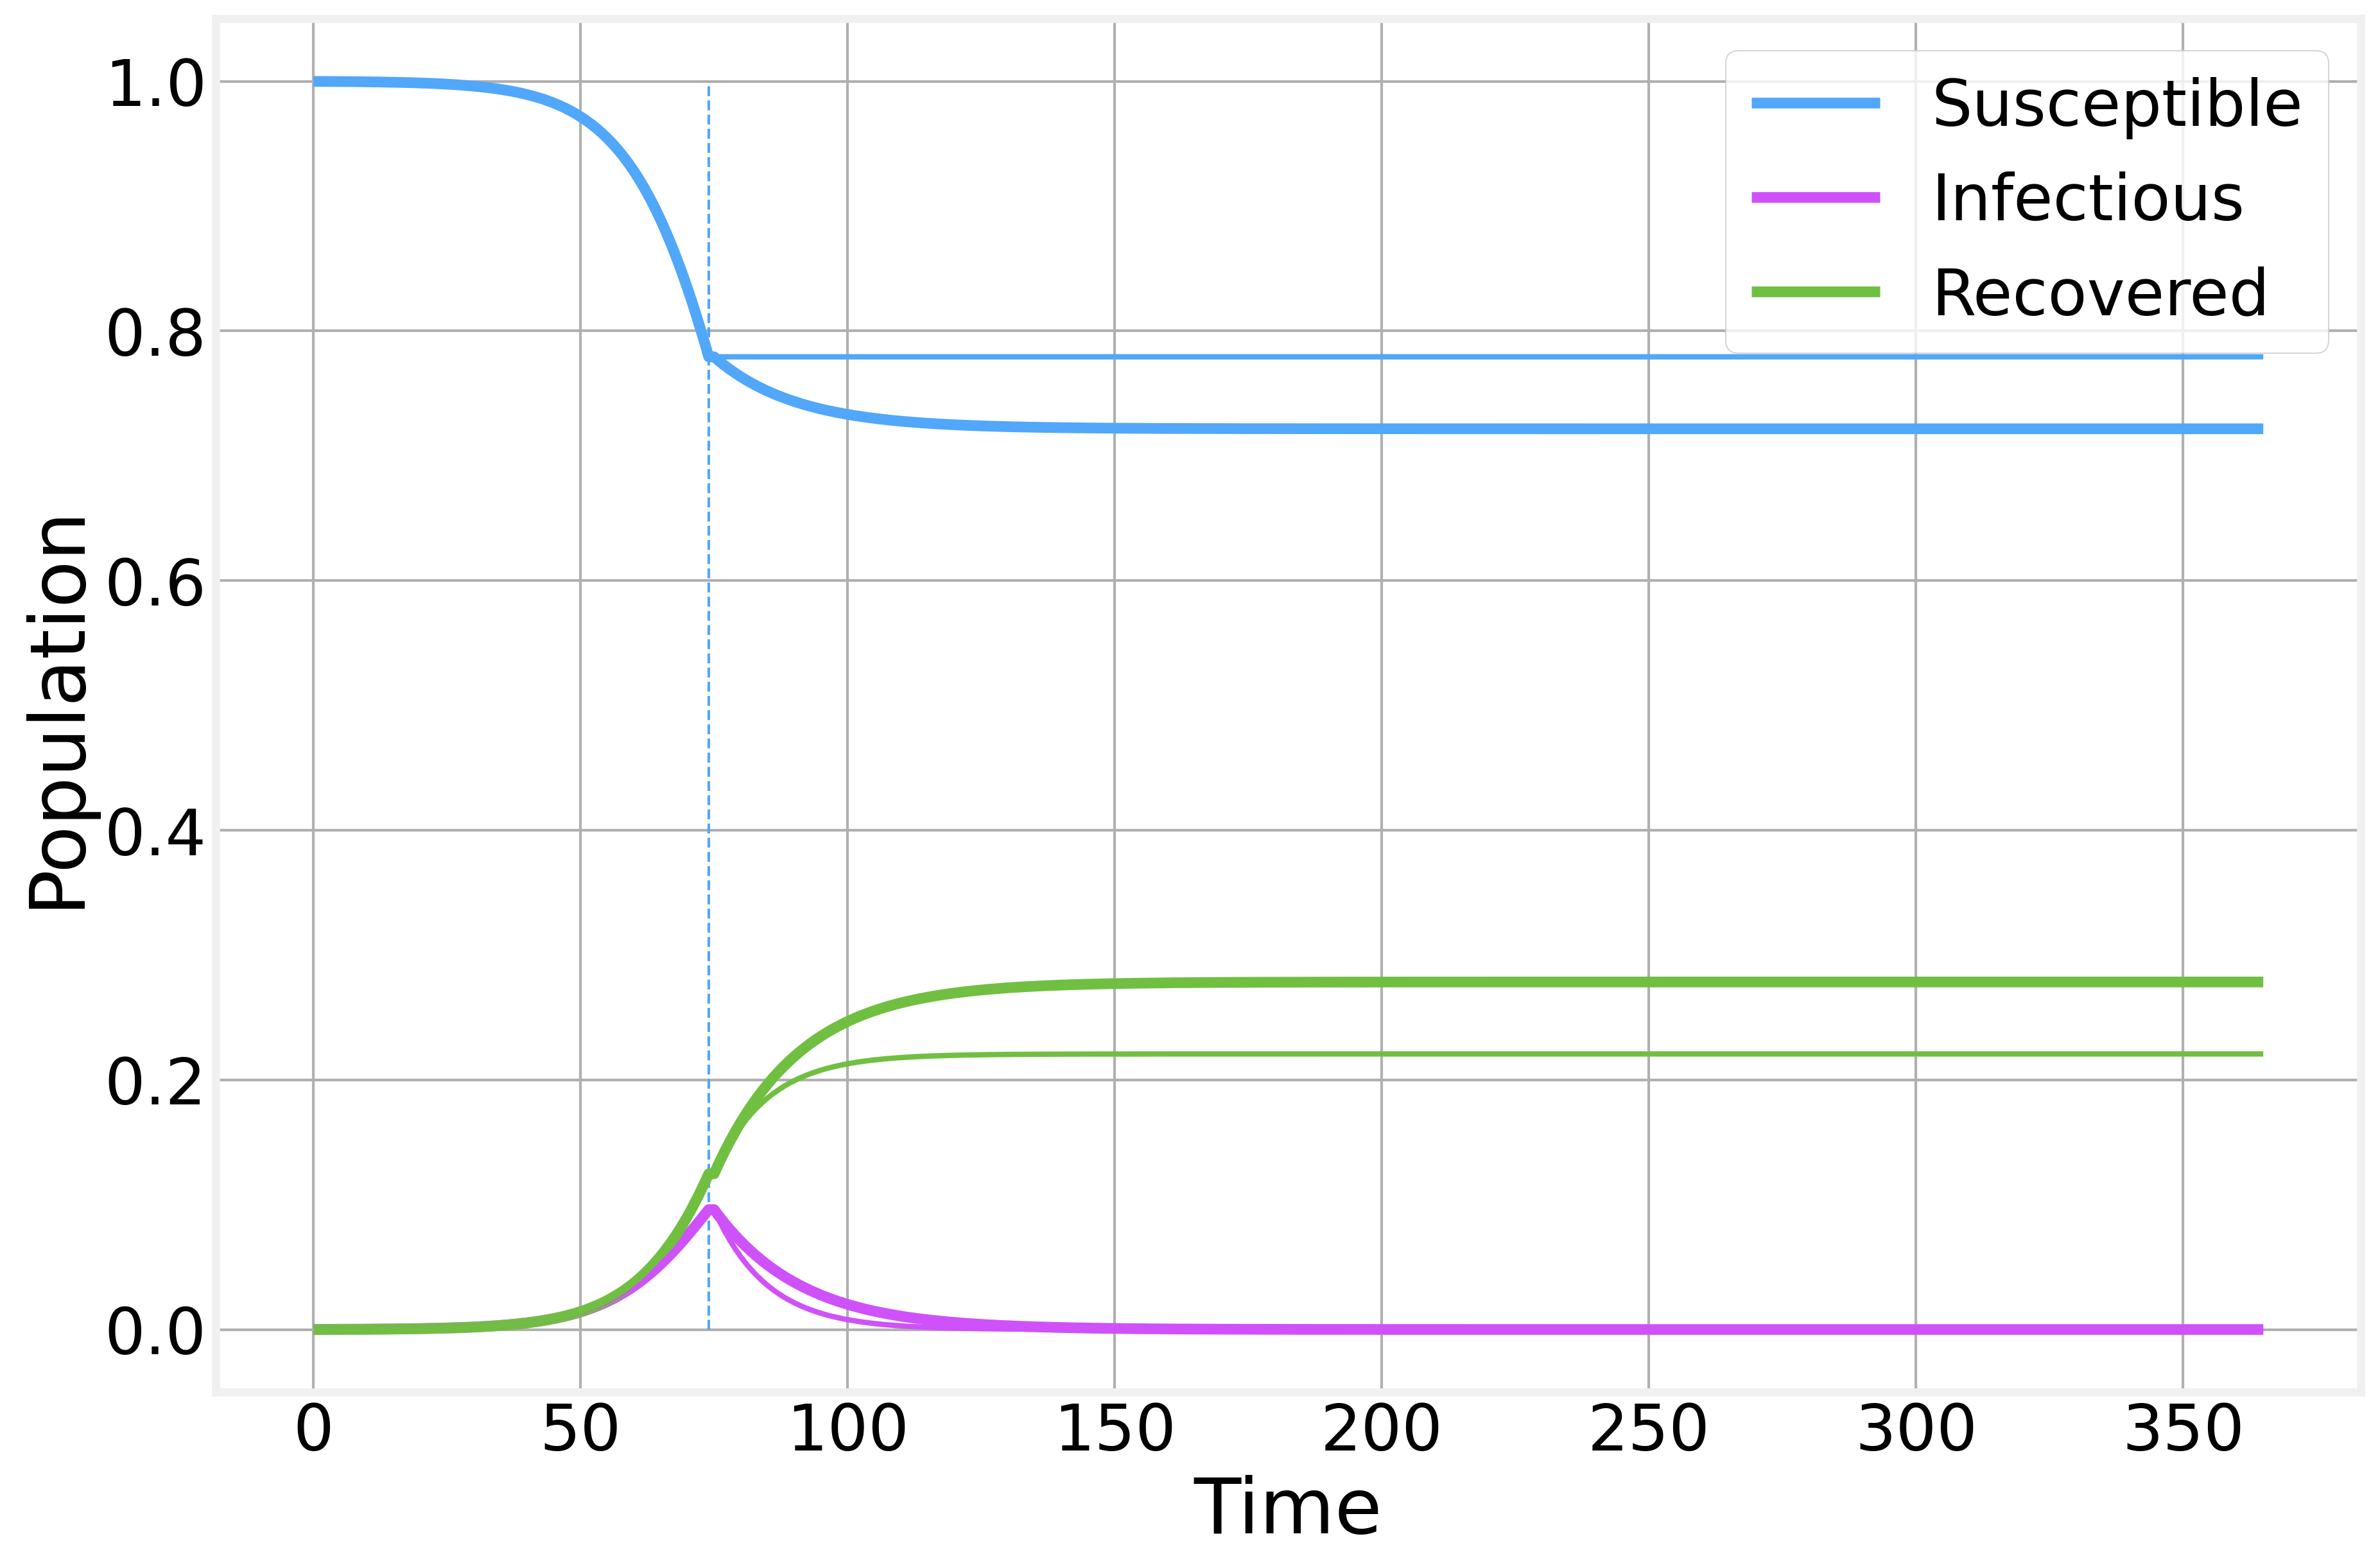

In [15]:
ax = (values2/N).plot()
ax.vlines(x=74, ymax=1, ymin=0, lw=1, linestyle='--')
(values.S/N).plot(ax=ax, lw=2, linestyle='-', c=colors[0])
(values.I/N).plot(ax=ax, lw=2, linestyle='-', c=colors[1])
(values.R/N).plot(ax=ax, lw=2, linestyle='-', c=colors[2])
ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

Naturally, this requries the social distancing procedure to continue for longer and at the end we'll have more people who have been infected. However, if we stop too early, we simply go back to business as usual

In [16]:
population = values2.iloc[100]
S0 = population.S
I0 = population.I
R0 = population.R


SIR2.integrate(365-99, S=S0, I=I0, R=R0)

values3 = values2.iloc[:100].copy()
values3 = pd.concat([values3, SIR2.values_], axis=0, ignore_index=True)

For comparison we now use the original SIR model withouth any intervention. 

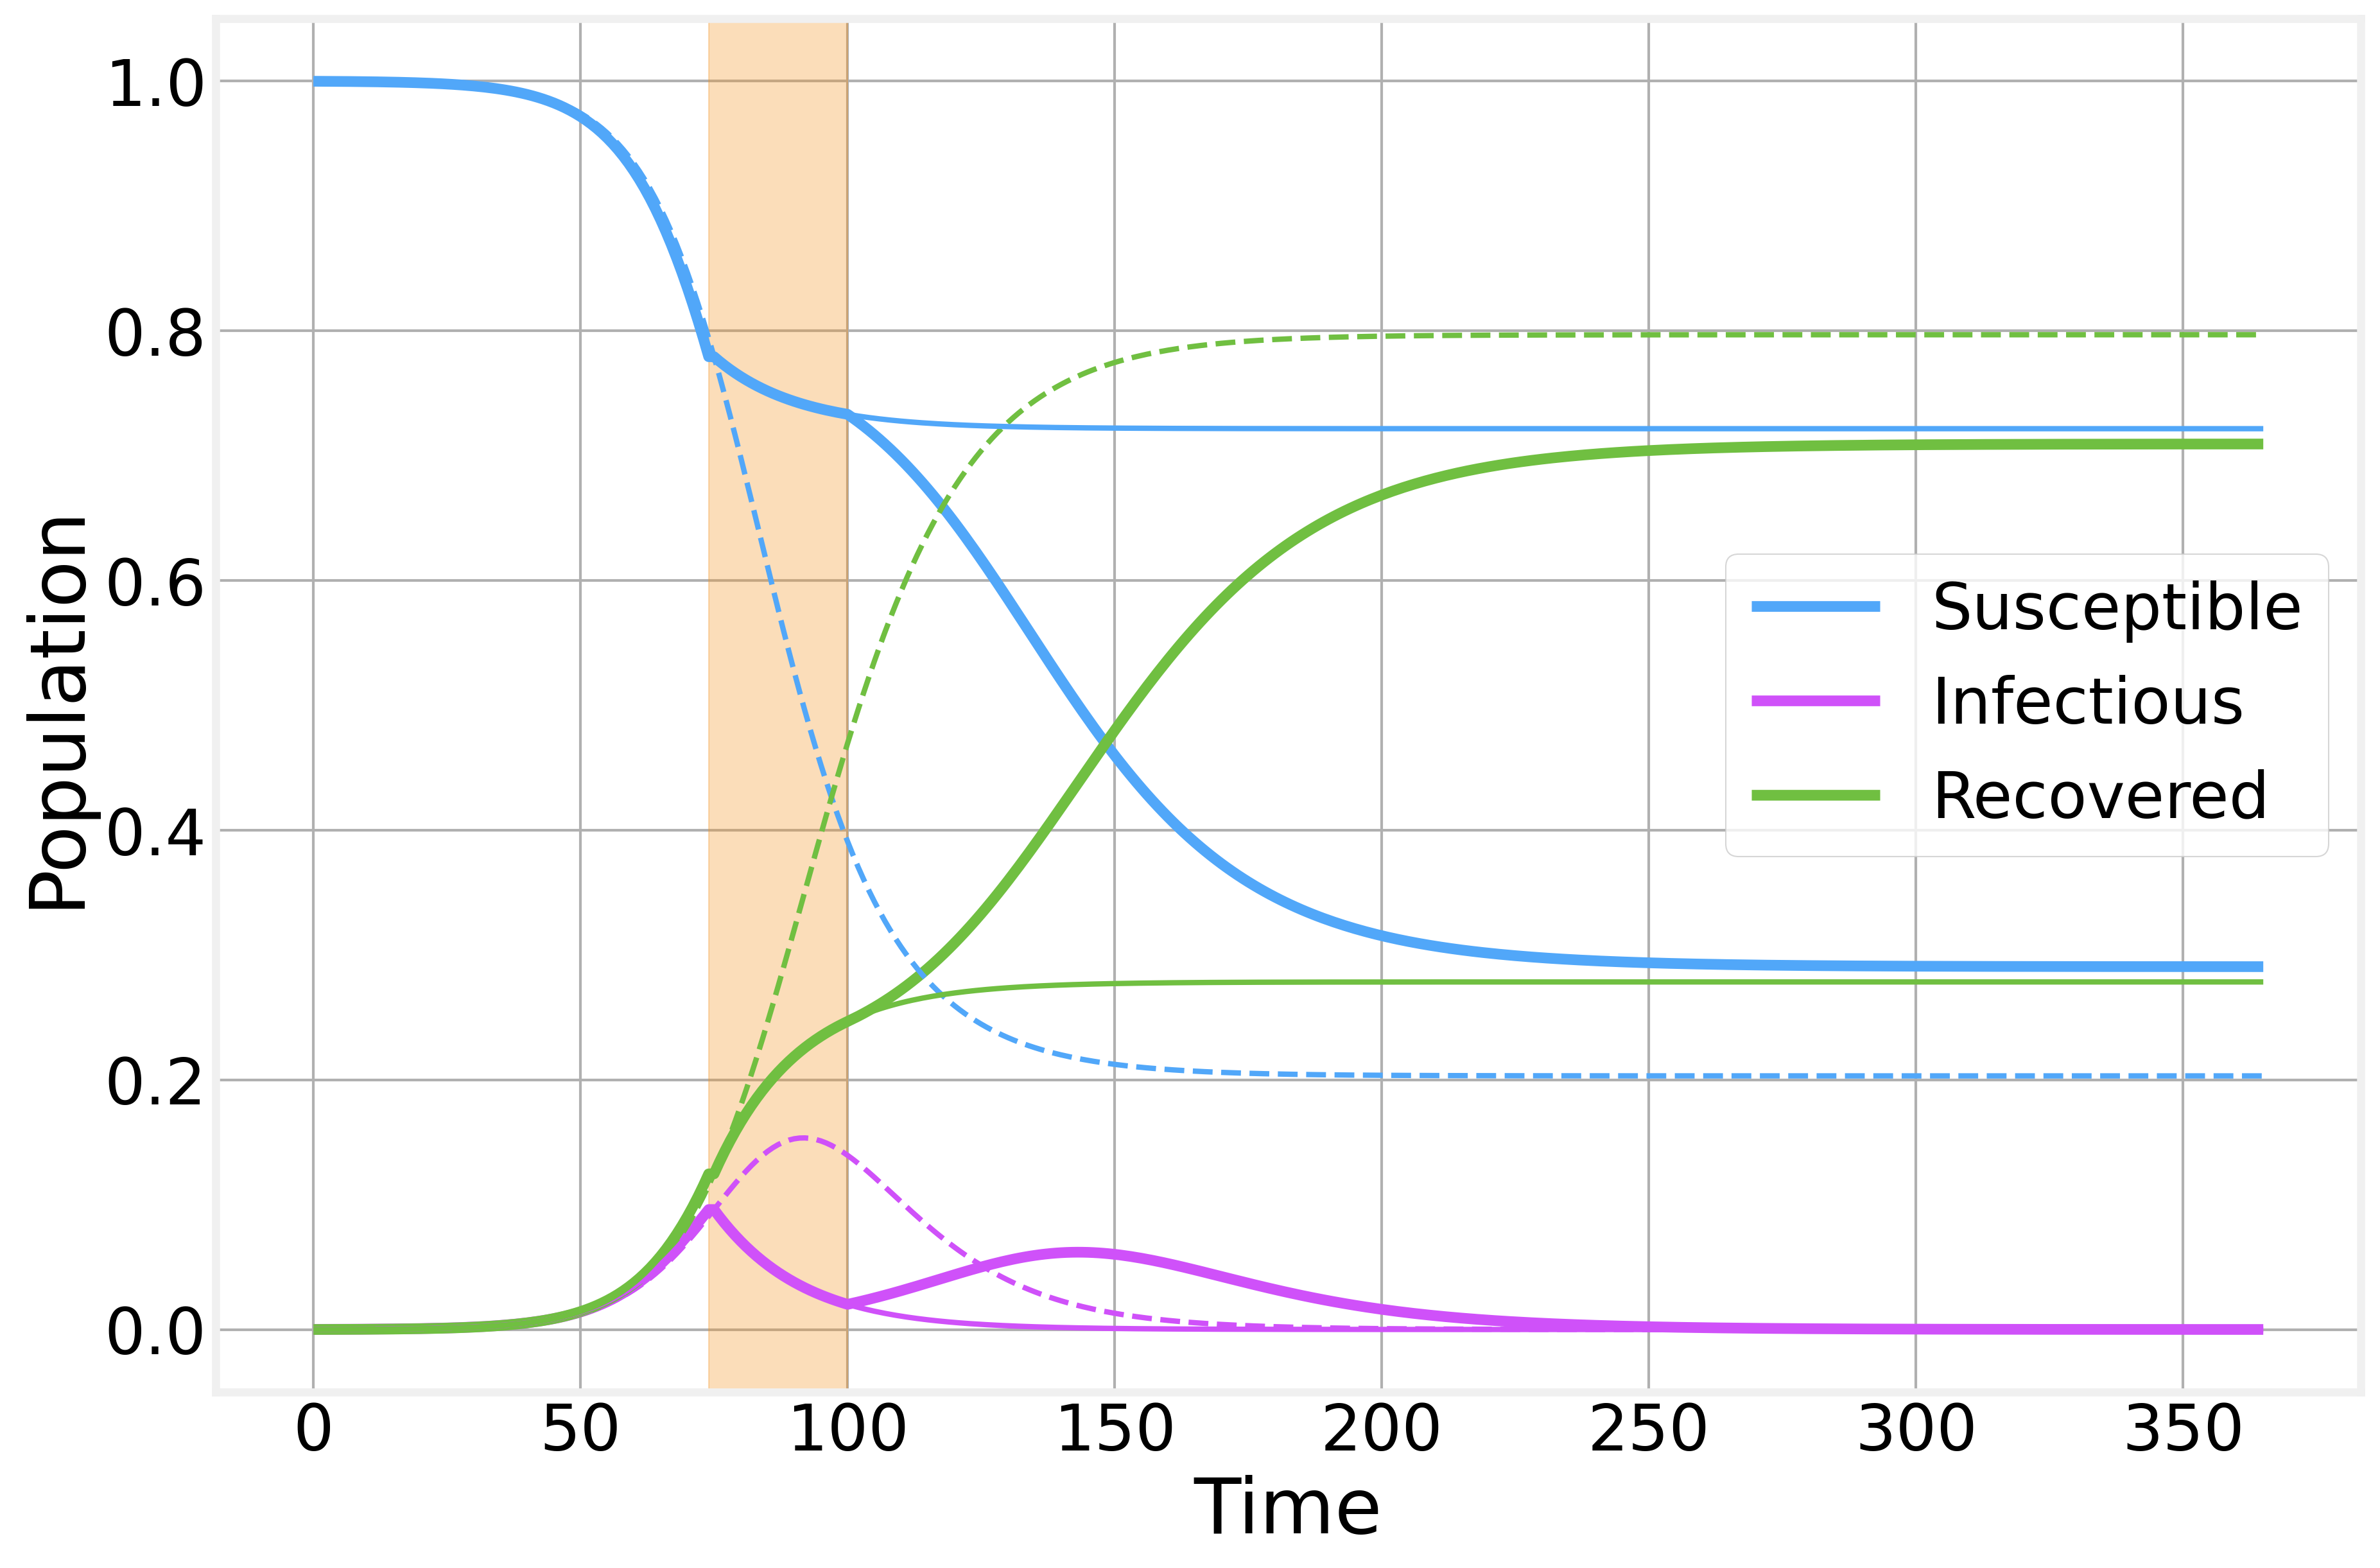

In [17]:
fig, ax = plt.subplots(1)

lines = (values3/N).plot(ax=ax)
ax.axvspan(xmin=74, xmax=100, alpha=0.3, color=colors[3])
(SIR.S/N).plot(ax=ax, lw=2, linestyle='--', c=colors[0], legend=False)
(SIR.I/N).plot(ax=ax, lw=2, linestyle='--', c=colors[1], legend=False)
(SIR.R/N).plot(ax=ax, lw=2, linestyle='--', c=colors[2], legend=False)

(values2.S/N).plot(ax=ax, lw=2, linestyle='-', c=colors[0])
(values2.I/N).plot(ax=ax, lw=2, linestyle='-', c=colors[1])
(values2.R/N).plot(ax=ax, lw=2, linestyle='-', c=colors[2])

ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Susceptible', 'Infectious', 'Recovered'])

And zooming in on the number of Infectious

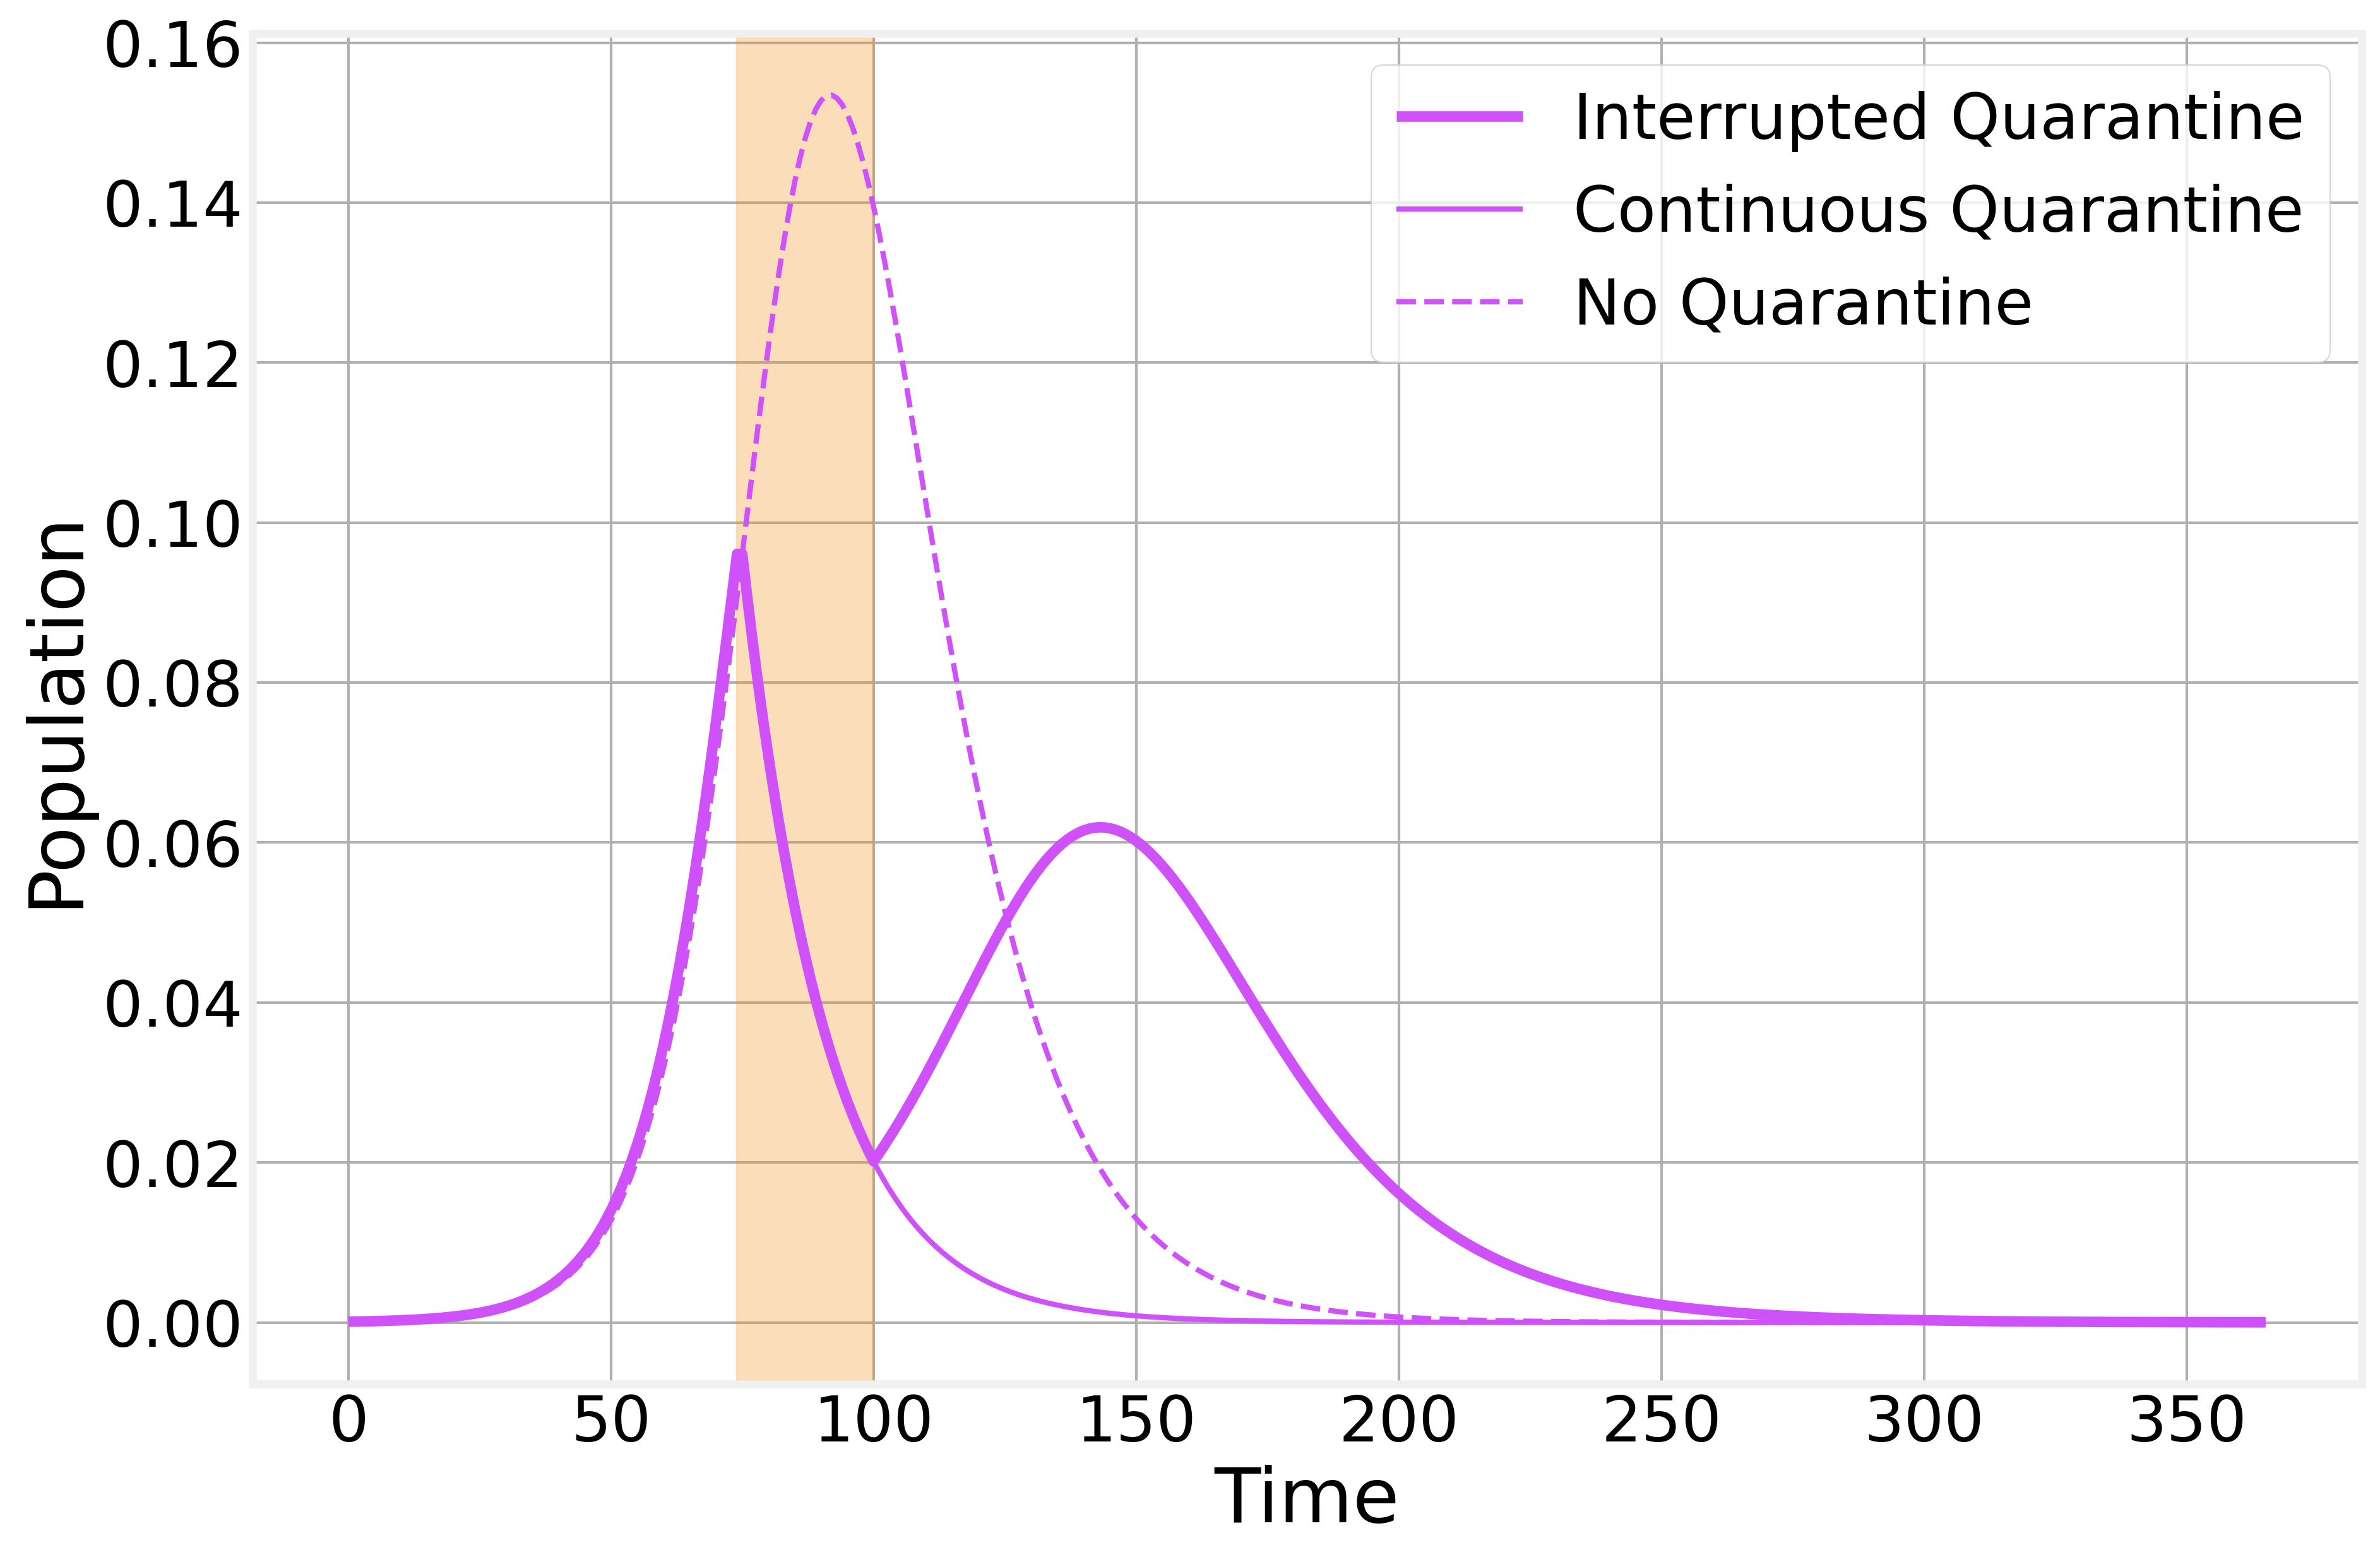

In [18]:
fig, ax = plt.subplots(1)

lines = (values3.I/N).plot(ax=ax, c=colors[1])
span = ax.axvspan(xmin=74, xmax=100, alpha=0.3, color=colors[3])
(values2.I/N).plot(ax=ax, lw=2, linestyle='-', c=colors[1])
(SIR.I/N).plot(ax=ax, lw=2, linestyle='--', c=colors[1])


ax.set_ylabel('Population')
ax.set_xlabel('Time')
ax.legend(['Interrupted Quarantine', 'Continuous Quarantine', 'No Quarantine', ])

As you can see, even a broken social distancing procedure is better than nothing. It buys time and reduces the number of overall infected people in the population.

<div style="width: 100%; overflow: hidden; float: center;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>